RuntimeError: stack expects each tensor to be equal size, but got [20] at entry 0 and [10] at entry 1

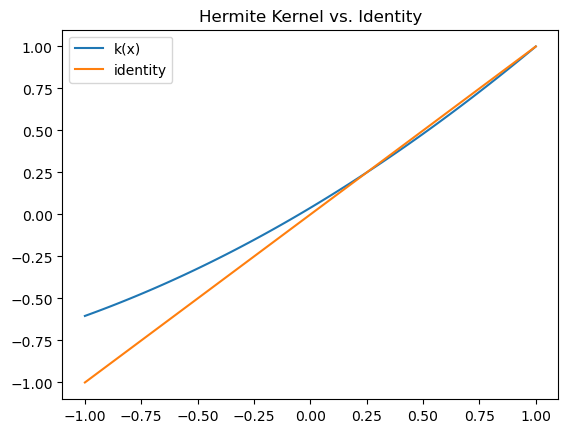

In [73]:
import torch 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


###############################################################################
# 1) Generate inputs with "diverse" correlations
###############################################################################
def generate_diverse_inputs(n, d, seed=0):
    """
    Generate n vectors in R^d whose pairwise correlations 
    spread more evenly in [-1,1], then scale by sqrt(d).
    """
    torch.manual_seed(seed)
    sines = torch.exp(-torch.linspace(0,2,n))
    sines = torch.linspace(0,1,n) # linear-ly spaced 
    # cosines = torch.sqrt(1-sines**2)
    X_2d = torch.stack([cosines, sines], dim=1)
    if d == 2:
        X = X_2d
    else:
        A = torch.randn(d, d)
        Q, _ = torch.linalg.qr(A)  # shape (d, d)
        X_nd = torch.zeros(n, d)
        X_nd[:, :2] = X_2d
        X = X_nd @ Q.T
    return X * np.sqrt(d)


###############################################################################
# 2) Hermite activation definition
###############################################################################
def make_hermite_activation(coefs):
    denom_list = []
    fact = 1
    for i in range(len(coefs)):
        denom_list.append(np.sqrt(fact))
        fact *= (i+1)

    denom = torch.tensor(denom_list, dtype=torch.float32)
    coefs_torch = torch.tensor(coefs, dtype=torch.float32)

    def hermite_activation(x):
        y = torch.zeros_like(x)
        for i, c in enumerate(coefs_torch):
            y += c * torch.special.hermite_polynomial_he(x, i) / denom[i]
        return y

    def hermite_activation_prime(x):
        yprime = torch.zeros_like(x)
        for i, c in enumerate(coefs_torch):
            if i == 0:
                continue
            yprime += c * i * torch.special.hermite_polynomial_he(x, i - 1) / denom[i]
        return yprime

    def hermite_kernel(rho):
        """
        kappa(rho) = sum_i (c^2_i) * rho^i
        """
        y = torch.zeros_like(rho)
        for i, c in enumerate(coefs):
            y += (c**2) * (rho**i)
        return y

    def hermite_kernel_prime(rho):
        """
        kappa'(rho) = sum_i i*(c^2_i) * rho^(i-1)
        """
        y = torch.zeros_like(rho)
        for i, c in enumerate(coefs):
            if i == 0:
                continue
            y += (c**2) * i * (rho**(i-1))
        return y
    
    return hermite_activation, hermite_activation_prime, hermite_kernel, hermite_kernel_prime


###############################################################################
# 3) RMS Norm and its Jacobian
###############################################################################
def rms_norm(x, eps=1e-5):
    norm = x.pow(2).mean(dim=1, keepdim=True).add(eps).sqrt()
    return x / norm

def rms_norm_jac(x, eps=1e-5):
    d_ = x.shape[0]
    r = x.pow(2).mean().add(eps).sqrt()
    I = torch.eye(d_, dtype=x.dtype, device=x.device)
    ggT = torch.ger(x, x)
    J = (1.0/r)*I - (1.0/(r**3 * d_))*ggT
    return J


###############################################################################
# 4) Empirical forward/backward (finite-width)
###############################################################################
def forward_backward(x, weights, f, f_prime, eps=1e-5):
    n, d_in = x.shape
    L = len(weights)

    zs, gs, hs = [], [], []

    # ======= Forward pass =======
    h = x
    for w in weights:
        z = h @ w
        g = f(z)
        h = rms_norm(g, eps=eps)
        zs.append(z)
        gs.append(g)
        hs.append(h)

    # ======= Backward pass =======
    final_dim = hs[-1].shape[1]
    jacs = [torch.eye(final_dim, dtype=x.dtype, device=x.device) for _ in range(n)]
    all_jacs = []
    for layer_idx in reversed(range(L)):
        w = weights[layer_idx]
        z = zs[layer_idx]
        g = gs[layer_idx]
        d_out = w.shape[1]

        for i in range(n):
            D_fp = torch.diag(f_prime(z[i]))
            J_rms = rms_norm_jac(g[i], eps=eps)
            jacs[i] = (J_rms @ D_fp @ w.T) @ jacs[i]

        all_jacs.append(torch.stack(jacs, dim=0))  # (n, d_layer, final_dim)

    all_jacs.reverse()

    # ======= Forward Gram =======
    forward_grams = []
    for h_ in hs:
        dim_ = h_.shape[1]
        G_ = (h_ @ h_.T) / dim_
        forward_grams.append(G_)

    # ======= Backward Gram =======
    backward_grams = []
    for j_ in all_jacs:
        j_flat = j_.view(n, -1)
        dim_ = j_flat.shape[1]
        G_ = (j_flat @ j_flat.T) / d_in
        backward_grams.append(G_)

    # ======= NTK =======
    ntks = []
    input_Gram_0 = (x @ x.T) / x.shape[1]
    for l in range(L):
        fwd_g = input_Gram_0 if l == 0 else forward_grams[l-1]
        bwd_g = backward_grams[l]
        ntk_ell = fwd_g * bwd_g
        ntks.append(ntk_ell)

    forward_grams = torch.stack(forward_grams, dim=0)
    backward_grams = torch.stack(backward_grams, dim=0)
    ntk = torch.stack(ntks, dim=0)

    return hs, all_jacs, forward_grams, backward_grams, ntk


###############################################################################
# 5) Mean-field theory for forward/backward/NTK
###############################################################################
def mean_field_forward_kernel(c0, kappa, n_layers):
    c_tensor = torch.zeros(n_layers+1, *c0.shape, dtype=c0.dtype, device=c0.device)
    c_tensor[0] = c0
    for ell in range(n_layers):
        c_tensor[ell+1] = kappa(c_tensor[ell])
    return c_tensor

def mean_field_backward_kernel(c_tensor, kappa_prime, n_layers):
    dotc_tensor = torch.zeros_like(c_tensor)
    dotc_tensor[n_layers] = 1.0
    for ell in reversed(range(n_layers)):
        dotc_tensor[ell] = dotc_tensor[ell+1] * kappa_prime(c_tensor[ell])
    return dotc_tensor

def mean_field_ntk(c_tensor, dotc_tensor, n_layers):
    ntk_tensor = torch.zeros(n_layers, *c_tensor.shape[1:], dtype=c_tensor.dtype, device=c_tensor.device)
    for ell in range(n_layers):
        ntk_tensor[ell] = c_tensor[ell] * dotc_tensor[ell+1]
    return ntk_tensor


###############################################################################
# 6) Demo usage, now with top-row-only plotting (i=0) and log10 color scale
###############################################################################
if __name__ == "__main__":
    # (A) Setup Hermite activation
    hermite_coefs = np.array([1,0,2,0], dtype=float)
    hermite_coefs[1] += 1.5 * sum(hermite_coefs)
    hermite_coefs /= np.sum(hermite_coefs**2)**0.5
    act, act_prime, k, k_prime = make_hermite_activation(hermite_coefs)

    # Just to show the custom "kernel" vs identity
    x_plot = torch.linspace(-1.,1.,100)
    plt.figure()
    plt.plot(x_plot, k(x_plot), label='k(x)')
    plt.plot(x_plot, x_plot, label='identity')
    plt.legend()
    plt.title("Hermite Kernel vs. Identity")

    # (B) Network/inputs
    d = 2000
    L = 50
    n = 10

    # Possibly reduce L if log(k'(1)) is large
    l_inv = torch.log(k_prime(torch.tensor([1.0]))).abs().item()
    if l_inv > 1e-3:
        L = min(L,int(10.0/l_inv))

    weights = [torch.randn(d, d)/(d**0.5) for _ in range(L)]
    X = generate_diverse_inputs(n=n, d=d, seed=42)

    # (C) Empirical kernels
    hs, jacs, forward_gram, backward_gram, ntk = forward_backward(X, weights, act, act_prime)

    # (D) Mean-field theory
    c0 = (X @ X.T) / d
    c_theory = mean_field_forward_kernel(c0, k, L)     
    dotc_theory = mean_field_backward_kernel(c_theory, k_prime, L)
    ntk_theory = mean_field_ntk(c_theory, dotc_theory, L)

    ###########################################################################
    # Plot only i=0 row (vs j=1..n-1), coloring by sign(rho_0j)*log10(|rho_0j|)
    ###########################################################################
    # 1) Gather color values
    all_vals = []
    for j in range(1, n):
        c_0j = c0[0,j].item()
        if abs(c_0j) < 1e-12:
            c_0j = 1e-12
        sign_ = 1.0 if c_0j >= 0 else -1.0
        val_ = sign_ * np.log10(abs(c_0j))
        all_vals.append(val_)

    minVal = min(all_vals)
    maxVal = max(all_vals)
    # decide whether we can do TwoSlopeNorm with vcenter=0
    use_two_slope = (minVal < 0 < maxVal)

    if use_two_slope:
        norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=minVal, vmax=maxVal)
    else:
        norm = mcolors.Normalize(vmin=minVal, vmax=maxVal)

    colormap = matplotlib.colormaps["RdBu"]

    def get_color_for_j(j):
        c_0j = c0[0,j].item()
        if abs(c_0j) < 1e-12:
            c_0j = 1e-12
        s_ = 1.0 if c_0j >= 0 else -1.0
        v_ = s_ * np.log10(abs(c_0j))
        return colormap(norm(v_))

    layers = np.arange(L)

    # ================ Forward Kernel, i'th row ================
    i = n-1
    fig, ax = plt.subplots(figsize=(8,5))
    for j in range(1, n):
        color = get_color_for_j(j)
        y_emp = forward_gram[:, i, j]
        y_the = c_theory[1:, i, j]
        ax.plot(layers, y_emp.detach().cpu().numpy(), color=color, linestyle='-')
        ax.plot(layers, y_the.detach().cpu().numpy(), color=color, linestyle='--')

    ax.set_title("Forward Kernel: i=0 vs. j=1..n-1")
    ax.set_xlabel("Layer index")
    ax.set_ylabel("Kernel value")

    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("sign(rho_0j)*log10(|rho_0j|)")
    plt.tight_layout()
    plt.show()

    # ================ Backward Kernel, i=0 row ================
    fig, ax = plt.subplots(figsize=(8,5))
    for j in range(1, n):
        color = get_color_for_j(j)
        y_emp = backward_gram[:, i, j]
        y_the = dotc_theory[1:, i, j]
        ax.plot(layers, y_emp.detach().cpu().numpy(), color=color, linestyle='-')
        ax.plot(layers, y_the.detach().cpu().numpy(), color=color, linestyle='--')

    ax.set_title("Backward Kernel: i=0 vs. j=1..n-1")
    ax.set_xlabel("Layer index")
    ax.set_ylabel("Kernel value")
    ax.set_yscale("log")

    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("sign(rho_0j)*log10(|rho_0j|)")
    plt.tight_layout()
    plt.show()

    # ================ NTK, i=0 row ================
    fig, ax = plt.subplots(figsize=(8,5))
    for j in range(1, n):
        color = get_color_for_j(j)
        y_emp = ntk[:, i, j] 
        y_the = ntk_theory[:, i, j]
        ax.plot(layers, y_emp.detach().cpu().numpy(), color=color, linestyle='-')
        ax.plot(layers, y_the.detach().cpu().numpy(), color=color, linestyle='--')

    ax.set_title("NTK: i=0 vs. j=1..n-1")
    ax.set_xlabel("Layer index")
    ax.set_ylabel("Kernel value")
    ax.set_yscale("log")

    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("sign(rho_0j)*log10(|rho_0j|)")
    plt.tight_layout()
    plt.show()


# torch module-based implementation 

In [41]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Optional
from dataclasses import dataclass
import math

class SimpleBatchNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.dim = dim

    def forward(self, x):
        # Compute mean and variance along batch dimension
        mean = x.mean(dim=0, keepdim=True)
        var = x.var(dim=0, unbiased=False, keepdim=True)
        return (x - mean) / torch.sqrt(var + self.eps)

class SimpleLayerNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.dim = dim

    def forward(self, x):
        # Compute mean and variance along feature dimension
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        return (x - mean) / torch.sqrt(var + self.eps)

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.dim = dim

    def forward(self, x):
        # Only variance reduction, no learnable parameters
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return x / rms

@dataclass
class MLPConfig:
    input_dim: int
    output_dim: int
    hidden_dims: List[int]
    activation: str = 'relu'
    use_norm: bool = True
    norm_type: str = 'batch'  # 'batch', 'layer', or 'rms'
    norm_position: str = 'post'  # 'pre' or 'post' activation
    weight_init: str = 'normal'  # 'normal' or 'uniform'
    residual_strength: float = 0.0

class NormalizationLayer(nn.Module):
    def __init__(self, dim: int, norm_type: str):
        super().__init__()
        if norm_type == 'batch':
            self.norm = SimpleBatchNorm(dim)
        elif norm_type == 'layer':
            self.norm = SimpleLayerNorm(dim)
        elif norm_type == 'rms':
            self.norm = RMSNorm(dim)
        else:
            raise ValueError(f"Unsupported normalization type: {norm_type}")

    def forward(self, x):
        return self.norm(x)

class ActivationLayer(nn.Module):
    def __init__(self, activation_type: str):
        super().__init__()
        if activation_type == 'relu':
            self.activation = nn.ReLU()
        elif activation_type == 'tanh':
            self.activation = nn.Tanh()
        elif activation_type == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_type == 'linear':
            self.activation = nn.Identity()
        else:
            raise ValueError(f"Unsupported activation: {activation_type}")

    def forward(self, x):
        return self.activation(x)

class MLPBlock(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, config: MLPConfig):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.config = config
        
        # Initialize main linear layer
        self.linear = nn.Linear(input_dim, output_dim, bias=True)
        self._initialize_weights()
        
        # Initialize normalization and activation
        if config.use_norm:
            self.norm = NormalizationLayer(output_dim, config.norm_type)
        else:
            self.norm = nn.Identity()
            
        self.activation = ActivationLayer(config.activation)
        
        # Residual projection if dimensions don't match
        self.needs_projection = input_dim != output_dim
        if self.needs_projection:
            self.residual_proj = nn.Linear(input_dim, output_dim, bias=False)
            self._initialize_residual()
        
        # Store norm position and residual strength
        self.norm_position = config.norm_position
        self.residual_strength = config.residual_strength

    def _initialize_weights(self):
        std = 1.0 / math.sqrt(self.input_dim)
        
        if self.config.weight_init == 'normal':
            nn.init.normal_(self.linear.weight, mean=0.0, std=std)
        elif self.config.weight_init == 'uniform':
            bound = math.sqrt(3) * std
            nn.init.uniform_(self.linear.weight, -bound, bound)
        
        if self.linear.bias is not None:
            nn.init.zeros_(self.linear.bias)

    def _initialize_residual(self):
        std = 1.0 / math.sqrt(self.input_dim)
        if self.config.weight_init == 'normal':
            nn.init.normal_(self.residual_proj.weight, mean=0.0, std=std)
        else:  # 'uniform'
            bound = math.sqrt(3) * std
            nn.init.uniform_(self.residual_proj.weight, -bound, bound)

    def forward(self, x):
        identity = x
        
        # Main forward path
        x = self.linear(x)
        
        if self.norm_position == 'pre':
            if self.config.use_norm:
                x = self.norm(x)
            x = self.activation(x)
        else:  # post
            x = self.activation(x)
            if self.config.use_norm:
                x = self.norm(x)
        
        # Apply residual connection with strength parameter
        if self.residual_strength > 0:
            if self.needs_projection:
                identity = self.residual_proj(identity)
            x = (1 - self.residual_strength**2) * x + self.residual_strength**2 * identity
            
        return x

class ConfigurableMLP(nn.Module):
    def __init__(self, config: MLPConfig):
        super().__init__()
        self.config = config
        
        # Build network using MLPBlocks
        layers = []
        
        # Input to first hidden layer
        if config.hidden_dims:
            layers.append(MLPBlock(config.input_dim, config.hidden_dims[0], config))
            
            # Hidden layers
            for i in range(len(config.hidden_dims) - 1):
                layers.append(MLPBlock(config.hidden_dims[i], config.hidden_dims[i + 1], config))
            
            # Last hidden to output
            layers.append(MLPBlock(config.hidden_dims[-1], config.output_dim, config))
        else:
            # Direct input to output if no hidden layers
            layers.append(MLPBlock(config.input_dim, config.output_dim, config))
        
        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

    def get_jacobian(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the per-sample gradient of the *sum of outputs* wrt all parameters.
        Returns a tensor of shape (batch_size, total_params).
        
        - We sum across the output dimension so that the Jacobian per sample
          is of shape (1, total_params).
        - If the output has shape (N, D), each row n in the returned Jacobian
          is d/d(theta) of sum(output[n,:]).
        """
        # Forward pass
        y = self.forward(x)  # shape (N, output_dim)
        
        # We will flatten the sum over the output dimension to get a scalar per sample.
        # So effectively, for each sample n, we compute sum_{d} y[n,d].
        batch_size = y.shape[0]
        
        # Collect all parameters in a list to maintain a consistent ordering
        params = list(self.parameters())
        
        # Prepare storage for the per-sample gradients
        total_params = sum(p.numel() for p in params)
        jac = torch.zeros(batch_size, total_params, device=x.device, dtype=x.dtype)
        
        # Compute gradients sample-by-sample
        # (An alternative is to use torch.autograd.functional.jacobian, but this is simpler
        #  to illustrate the concept.)
        for n in range(batch_size):
            # Zero the gradients
            self.zero_grad()
            
            # We take the sum over output dims for sample n
            y[n].sum().backward(retain_graph=True if n < (batch_size - 1) else False)
            
            # Now collect the gradients wrt each parameter
            offset = 0
            for p in params:
                numel = p.numel()
                if p.grad is not None:
                    jac[n, offset:offset+numel] = p.grad.view(-1)
                offset += numel
        
        return jac

    def compute_ntk(self, x1: torch.Tensor, x2: Optional[torch.Tensor] = None) -> List[torch.Tensor]:
        """
        Given two input batches x1 and x2, compute the layer-wise NTK:
        
        For each layer L, we gather the gradients w.r.t. parameters belonging to L only,
        and compute the inner product (J1_L @ J2_L^T), producing a kernel matrix
        of shape (x1.size(0), x2.size(0)).
        
        Returns:
            A list of Tensors, each of shape (x1.size(0), x2.size(0)),
            where len(list) = number of layers in the model.
        """
        if x2 is None:
            x2 = x1
        
        # Get full-model Jacobians for each batch
        J1 = self.get_jacobian(x1)  # (N1, P)
        J2 = self.get_jacobian(x2)  # (N2, P)
        
        # Now we need to figure out which parameters in the big flattened vector
        # belong to which layer. We track the (start, end) indices of each layer's parameters.
        
        layer_param_ranges = []
        current_index = 0
        
        # We'll match the exact ordering that self.parameters() yields:
        param_list = list(self.parameters())  # same order used in get_jacobian
        layer_idx_for_param = []
        
        # Map each parameter to its layer index
        # (We do a small search: each MLPBlock's parameters appear in order,
        #  so we can track them block by block.)
        block_to_param_ids = []
        param_counter = 0
        
        for li, layer in enumerate(self.layers):
            layer_params = list(layer.parameters())
            block_to_param_ids.append([])
            for lp in layer_params:
                # This param matches param_list[param_counter] (same order)
                block_to_param_ids[-1].append(param_counter)
                param_counter += 1
        
        # Now build up the segments for each layer
        # We'll have one contiguous segment per layer
        # (weights + bias for that layer).
        # This assumes that each block's parameters appear contiguously in param_list,
        # which should be true as long as we haven't interspersed any other modules.
        segments = []
        
        offset = 0
        for li, param_ids in enumerate(block_to_param_ids):
            layer_numel = 0
            for pid in param_ids:
                p = param_list[pid]
                layer_numel += p.numel()
            segments.append(layer_numel)
        
        # Create the (start, end) ranges
        start = 0
        layer_param_ranges = []
        for numel in segments:
            layer_param_ranges.append((start, start + numel))
            start += numel
        
        # Finally compute the NTK for each layer
        ntk_per_layer = []
        N1 = J1.shape[0]
        N2 = J2.shape[0]
        
        for (start, end) in layer_param_ranges:
            # Extract the slice of the Jacobian corresponding to the current layer
            J1_layer = J1[:, start:end]  # shape (N1, layer_numel)
            J2_layer = J2[:, start:end]  # shape (N2, layer_numel)
            
            # The layer-wise NTK is the matrix of dot products:
            # shape (N1, N2)
            ntk_layer = J1_layer @ J2_layer.t()
            ntk_per_layer.append(ntk_layer)
        
        return ntk_per_layer


# Example usage
if __name__ == "__main__":
    # Define MLP configuration
    config = MLPConfig(
        input_dim=64,
        hidden_dims=[500]*5,  # Three hidden layers
        output_dim=32,
        activation='relu',
        use_norm=True,
        norm_type='rms',
        norm_position='post',
        weight_init='uniform',
        residual_strength=0.5
    )
    
    # Create model
    model = ConfigurableMLP(config)
    
    # Generate sample inputs
    x1 = torch.randn(2, 64)
    
    # Compute NTK
    ntks = model.compute_ntk(x1, x1)
    
    # Print NTK shapes for each layer
    for i, ntk in enumerate(ntks):
        print(f"Layer {i} NTK shape: {ntk.shape}")  # Should be (10, 15) for each layer


tensor([0.0000, 0.5862, 0.7545, 0.8469, 0.9024, 0.9371, 0.9592, 0.9734, 0.9826,
        0.9886, 0.9926, 0.9951, 0.9968, 0.9979, 0.9986, 0.9991, 0.9994, 0.9996,
        0.9997, 0.9998])